In [1]:
import abtem
import dask
import matplotlib.pyplot as plt
import numpy as np
from ase.cluster import Decahedron
from dask.distributed import Client

(examples:prism_quickstart)=
# PRISM quickstart

This is a short example of running a STEM simulation with the PRISM algorithm. See our [tutorial](tutorials:prism) for a more in depth description.  

## Configure

We start by customizing our configuration, see our [documentation on configuration](reference:configuration). 

In [2]:
abtem.config.set({"device": "cpu"})

abtem.config.set({"fft": "mkl"})

To run the simulation using a distributed scheduler we create a Dask `Client`, see our [walkthrough on parallelization](walkthrough:parallelization).

In [3]:
client = Client()

2022-11-16 15:45:48,519 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/_p/k7hrlnh132n933827sxdjkrm0000gn/T/dask-worker-space/worker-ilg1a7d6', purging


## Atomic model

We create an atomic model of a decahedral copper nanoparticle. See [walkthrough](walkthrough:atomic_models) and [tutorial](tutorials:advanced_atomic_models) on creating atomic models.

In [4]:
atoms = Decahedron("Cu", 10, 2, 0)
atoms.rotate("x", -30)
atoms.center(vacuum=4)

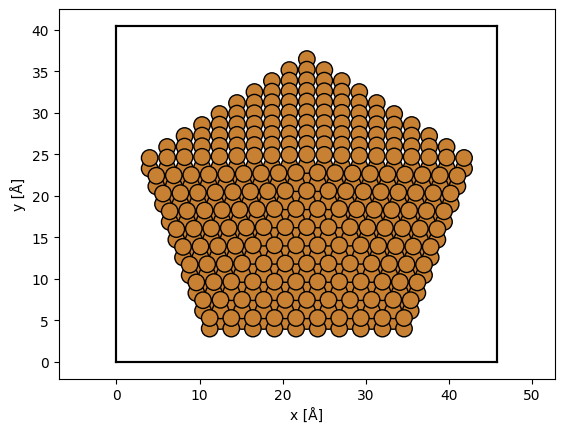

In [5]:
abtem.show_atoms(atoms, plane="xy", merge=0.5);

## Potential with frozen phonons

We create `FrozenPhonons` with a standard deviation of atomic displacements of $0.07 \ \mathrm{Å}$, see our [walkthrough on frozen phonons](walkthrough:frozen_phonons). We then create a standard potential with $1024\times1024$ grid points with a slice thickness of $2 \ \mathrm{Å}$, see our [walkthrough on potential](walkthrough:potentials).

In [11]:
frozen_phonons = abtem.FrozenPhonons(atoms, 10, {"Cu": 0.07})

potential = abtem.Potential(
    frozen_phonons,
    gpts=768,
    slice_thickness=2,
)

## Create SMatrix

We create a the SMatrix by providing our potential, an acceleration voltage $150 \ \mathrm{eV}$, a cutoff of the plane wave expansion of the probe of $20 \ \mathrm{mrad}$ and an interpolation factor of 4 in both $x$ and $y$. See our [tutorial on PRISM](tutorials:prism)

In [12]:
s_matrix = abtem.SMatrix(
    potential=potential, energy=150e3, planewave_cutoff=20, interpolation=4
)

The S-Matrix is four-dimensional, there are ten instances 

In [13]:
s_matrix.shape

(10, 163, 768, 768)

## Create contrast transfer function

To include defocus, spherical aberration and other phase aberrations, we should define a contrast transfer function. Here we create one with a spherical aberration of $20 \ \mu m$, the defocus is adjusted to the according [Scherzer defocus]() .

In [9]:
Cs = 20e-6 * 1e10  # 20 micrometers

defocus = abtem.transfer.scherzer_defocus(Cs=Cs, energy=s_matrix.energy)

ctf = abtem.CTF(Cs=Cs, defocus=defocus)

# ctf.defocus

We always ensure that the interpolation factor is sufficiently small to avoid self-interaction errors. We can check that by showing the equivalent probe at the entrance and exit plane.

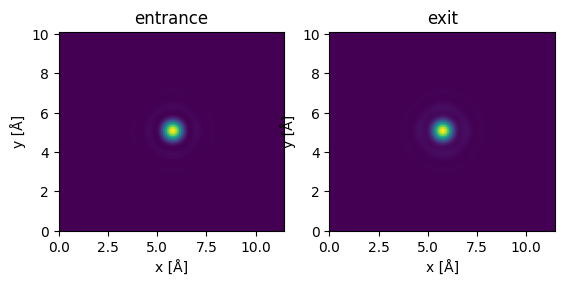

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2)
s_matrix.equivalent_probe(plane="entrance").show(ax=ax1, title="entrance")
s_matrix.equivalent_probe(plane="exit").show(ax=ax2, title="exit");

We should also check that our real space sampling is good enough for detecting electrons at our desired detector angles. In this case up to $165 \ \mathrm{mrad}$. See our [description of sampling](appendix:antialiasing).

In [38]:
s_matrix.cutoff_angles

(165.12427635020188, 165.22860223619813)

## Create a CTF, a detector and a scan

In [16]:
detectors = abtem.FlexibleAnnularDetector()

measurement = s_matrix.scan(detectors=detectors)

In [17]:
measurement.array

dask.array<mean_agg-aggregate, shape=(138, 122, 73, 1), dtype=float32, chunksize=(35, 122, 73, 1), chunktype=numpy.ndarray>

In [18]:
measurement.compute()

## Integrate "flexible" measurement

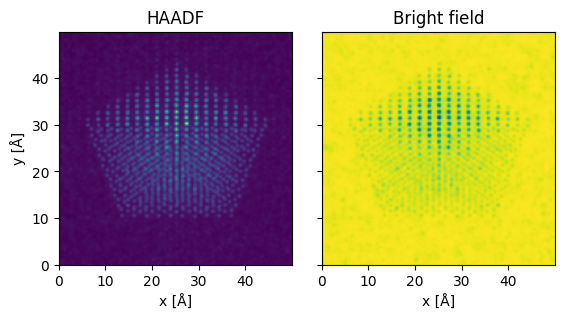

In [96]:
integrated_measurement = abtem.stack(
    (measurement.integrate_radial(50, 150), measurement.integrate_radial(0, 20)),
    axis_metadata=("HAADF", "Bright field"),
)

integrated_measurement.show(explode=True);

## Postprocess simulation result

In [ ]:
filtered_measurement = integrated_measurement.gaussian_filter(0.35)

(<Figure size 640x480 with 2 Axes>, <Axes: xlabel='x [Å]', ylabel='y [Å]'>)

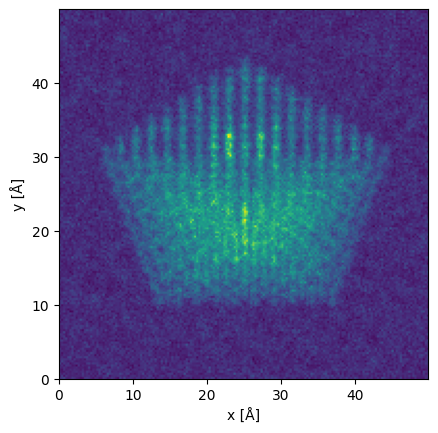

In [67]:
noisy_measurement = filtered_measurement.poisson_noise(dose_per_area=1e5)

noisy_measurement.show(title)

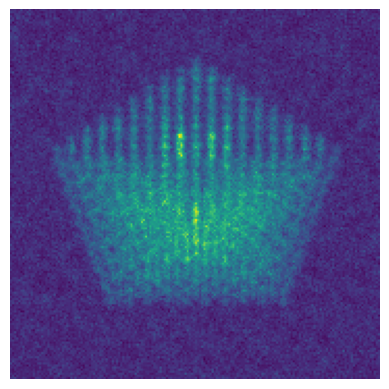

In [68]:
fig, ax = noisy_measurement.show()
ax.axis("off")
plt.savefig("../thumbnails/prism_quickstart.png", bbox_inches="tight", pad_inches=0)